In [1]:
import numpy as np
import os
import pandas as pd
import h5py
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox.utils import set_random_seed
from toolbox.plt_utils import density_scatter

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [4]:
# set random seed for reproducibility
set_random_seed(seed=42)

2026-01-19 23:42:36.410206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2026-01-19 23:42:36.410592: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# Check ziwei s models

In [6]:
import tensorflow as tf
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/others_models/ziwei/K562_h3k27ac/model_4k_count_only/model_split000"
o = tf.saved_model.load(p)

In [7]:
for v in o.variables:
    print(v.name, v.shape)

main_conv_0/kernel:0 (21, 4, 512)
main_conv_0/bias:0 (512,)
main_dil_conv_1/kernel:0 (3, 512, 512)
main_dil_conv_1/bias:0 (512,)
main_dil_conv_2/kernel:0 (3, 512, 512)
main_dil_conv_2/bias:0 (512,)
main_dil_conv_3/kernel:0 (3, 512, 512)
main_dil_conv_3/bias:0 (512,)
main_dil_conv_4/kernel:0 (3, 512, 512)
main_dil_conv_4/bias:0 (512,)
main_dil_conv_5/kernel:0 (3, 512, 512)
main_dil_conv_5/bias:0 (512,)
main_dil_conv_6/kernel:0 (3, 512, 512)
main_dil_conv_6/bias:0 (512,)
main_dil_conv_7/kernel:0 (3, 512, 512)
main_dil_conv_7/bias:0 (512,)
main_dil_conv_8/kernel:0 (3, 512, 512)
main_dil_conv_8/bias:0 (512,)
main_dil_conv_9/kernel:0 (3, 512, 512)
main_dil_conv_9/bias:0 (512,)
main_profile_head/kernel:0 (75, 512, 2)
main_profile_head/bias:0 (2,)
main_counts_head/kernel:0 (512, 1)
main_counts_head/bias:0 (1,)
profile_predictions/kernel:0 (1, 4, 2)
profile_predictions/bias:0 (2,)
logcounts_predictions/kernel:0 (2, 1)
logcounts_predictions/bias:0 (1,)
total:0 ()
count:0 ()


In [9]:
# find the kernel
W = next(v for v in o.variables if v.name == "logcounts_predictions/kernel:0").numpy()
# shape: (2, 1)

# flatten for convenience
w = W[:, 0]

w

array([-0.37947962,  1.1821533 ], dtype=float32)

These are the only ziwei models on k562 h3k27ac I foudn that seem to be count only (profile related loss is null -- see model_split000.history.json)

- https://mitra.stanford.edu/kundaje/oak/ziwei75/histone_mark/exp/K562_h3k27ac/model_2k_50bp_counts/
- https://mitra.stanford.edu/kundaje/oak/ziwei75/histone_mark/exp/K562_h3k27ac/model_2k_50bp_counts_2/
- https://mitra.stanford.edu/kundaje/oak/ziwei75/histone_mark/exp/K562_h3k27ac/model_2k_multiscale_loss/

# Check chip-ctrl correaltion in TF chip seq (CTCF in k562)

In [5]:
def get_corre(peaks, inputc_minus, inputc_plus, chip_minus, chip_plus):
    df = pd.read_csv(
        p,
        sep="\t",
        header=None,
        index_col=False,
    )
    df["length"] = df[2] - df[1]
    df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

    import pyBigWig
    chip_minus_bw = pyBigWig.open(chip_minus)
    chip_plus_bw = pyBigWig.open(chip_plus)
    inputc_minus_bw = pyBigWig.open(inputc_minus)
    inputc_plus_bw = pyBigWig.open(inputc_plus)
    def get_cts(
        peaks_df,
        bw,
        width,
        get_total_cts: bool = False,
    ):
        vals = []

        for _, r in peaks_df.iterrows():
            # w = r['length'] if width is None else width
            if not get_total_cts:
                vals.append(
                    np.nan_to_num(bw.values(r['chrom'],
                                            r['start'],
                                            r['end']))
                )
            else:
                vals.append(np.array([
                    np.nansum(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
                ]))

        return vals

    chip_minus_cts = get_cts(df, chip_minus_bw, None, get_total_cts=True)
    chip_plus_cts = get_cts(df, chip_plus_bw, None, get_total_cts=True)
    inputc_minus_cts = get_cts(df, inputc_minus_bw, None, get_total_cts=True)
    inputc_plus_cts = get_cts(df, inputc_plus_bw, None, get_total_cts=True)

    chip_minus_cts = np.array([v[0] for v in chip_minus_cts]).squeeze()
    chip_plus_cts = np.array([v[0] for v in chip_plus_cts]).squeeze()
    inputc_minus_cts = np.array([v[0] for v in inputc_minus_cts]).squeeze()
    inputc_plus_cts = np.array([v[0] for v in inputc_plus_cts]).squeeze()

    # pool
    chip_cts = chip_minus_cts + chip_plus_cts
    inputc_cts = inputc_minus_cts + inputc_plus_cts

    return chip_cts, inputc_cts

In [7]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/peak_outlier_removal/peaks_inliers.bed"
inputc_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/process_encode_chip/control_minus.bw"
inputc_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/process_encode_chip/control_plus.bw"
chip_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/process_encode_chip/minus.bw"
chip_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/process_encode_chip/plus.bw"

In [ ]:
chip_cts, inputc_cts = get_corre(p, inputc_minus, inputc_plus, chip_minus, chip_plus)

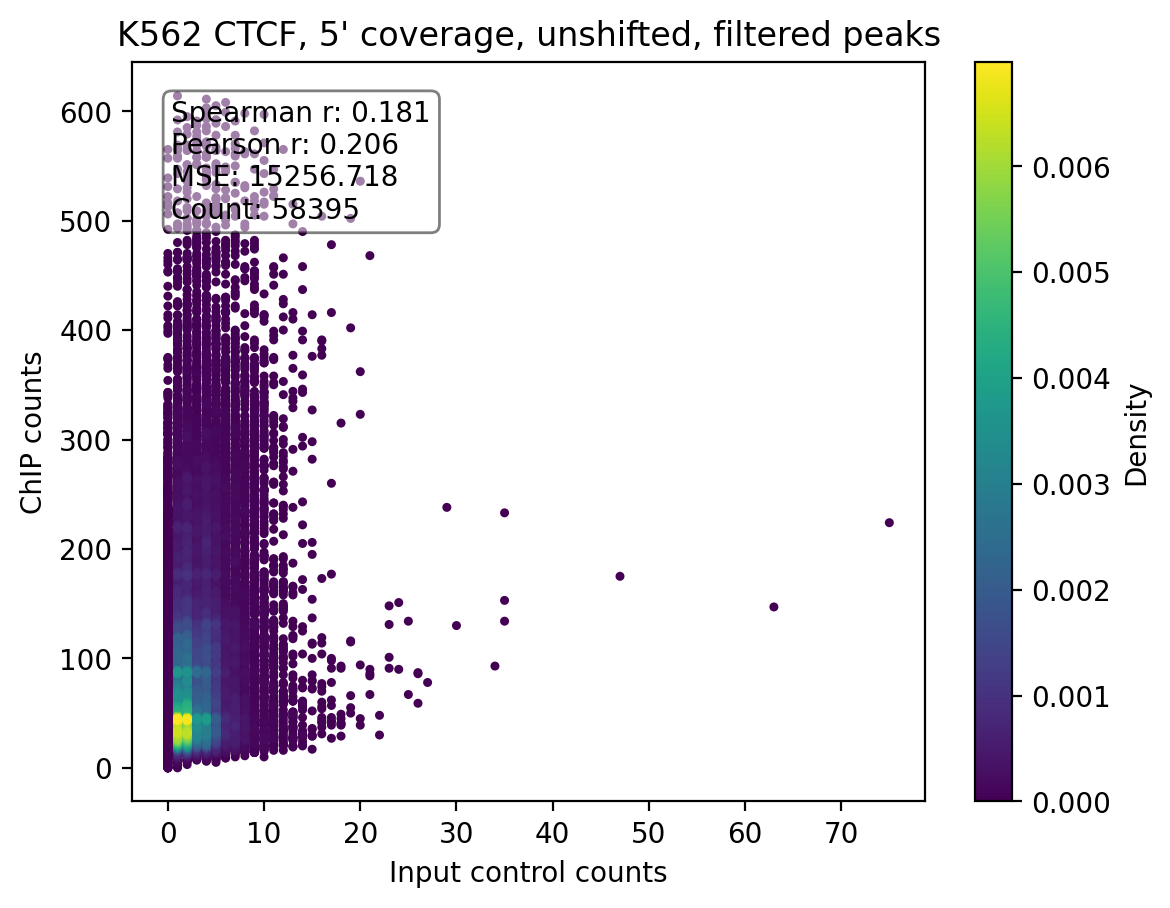

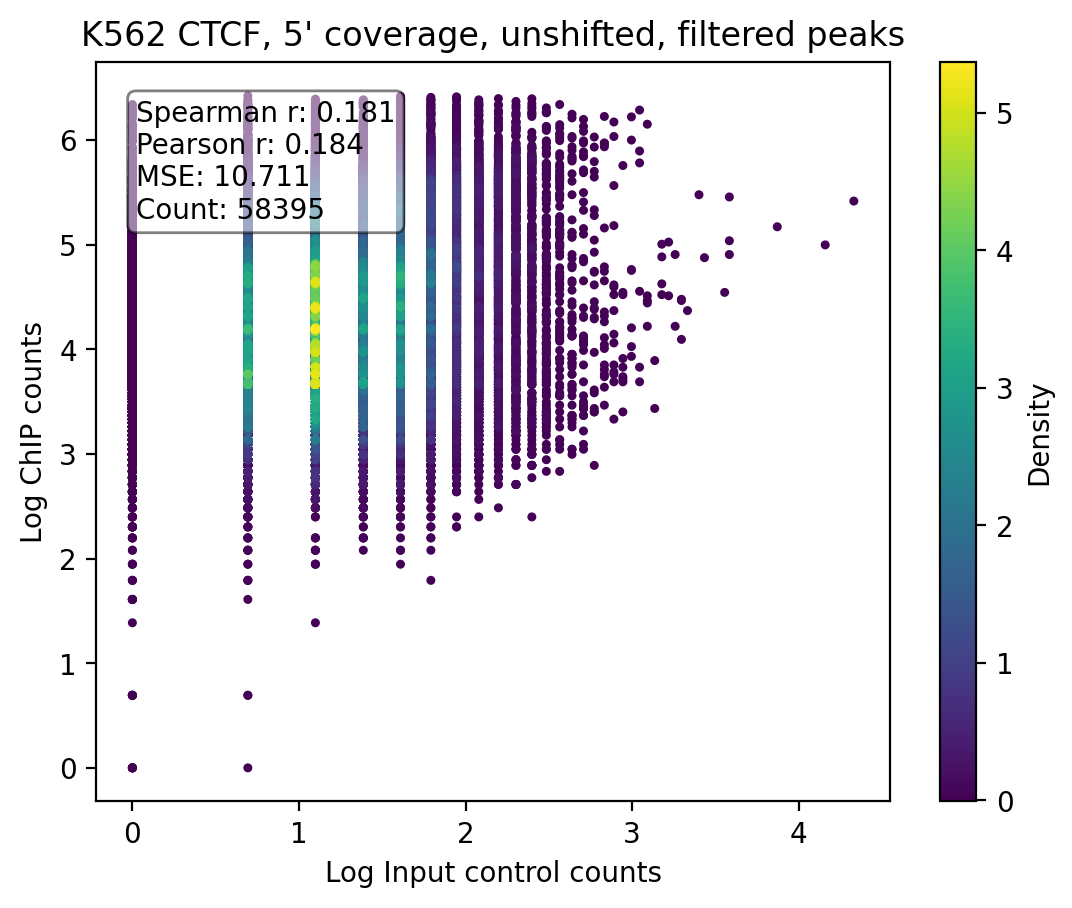

In [6]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 CTCF, 5' coverage, unshifted, filtered peaks")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 CTCF, 5' coverage, unshifted, filtered peaks")
plt.show()

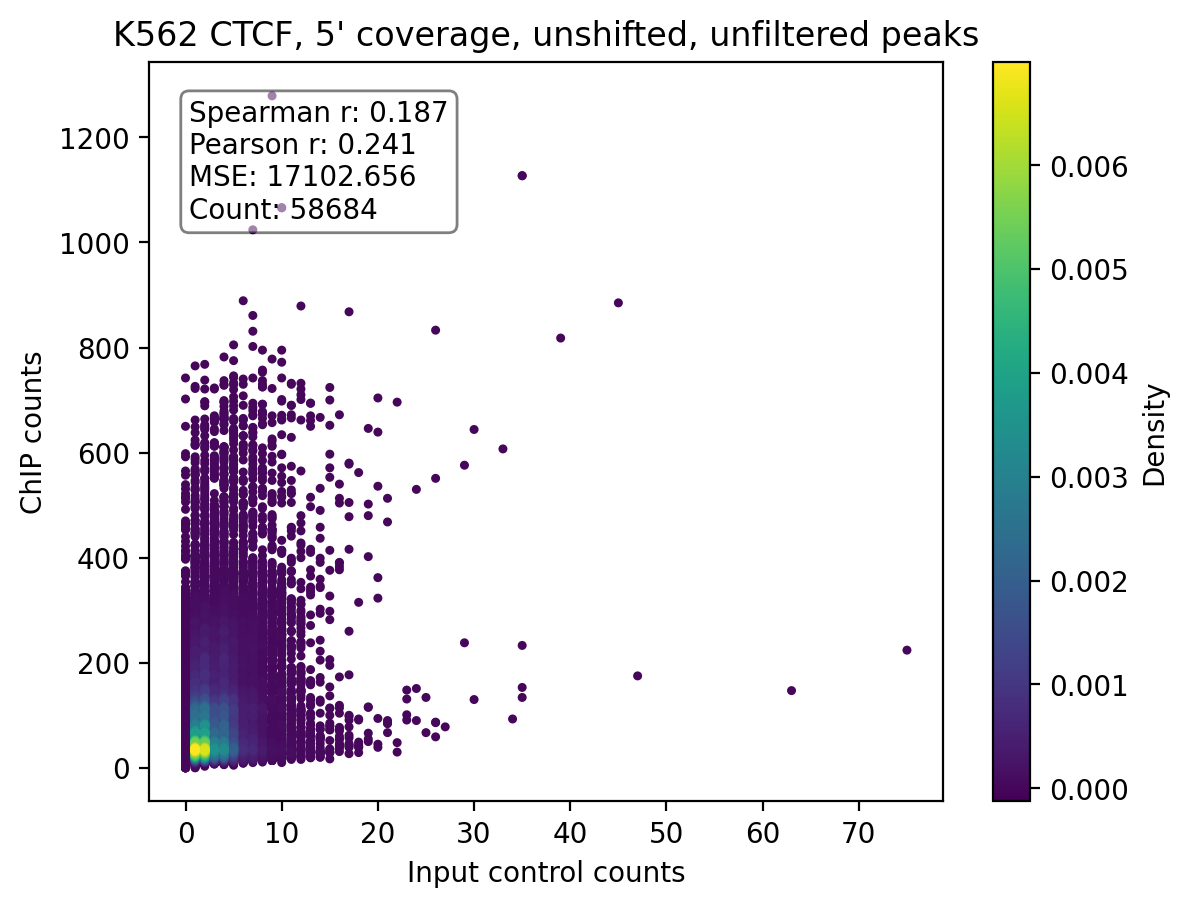

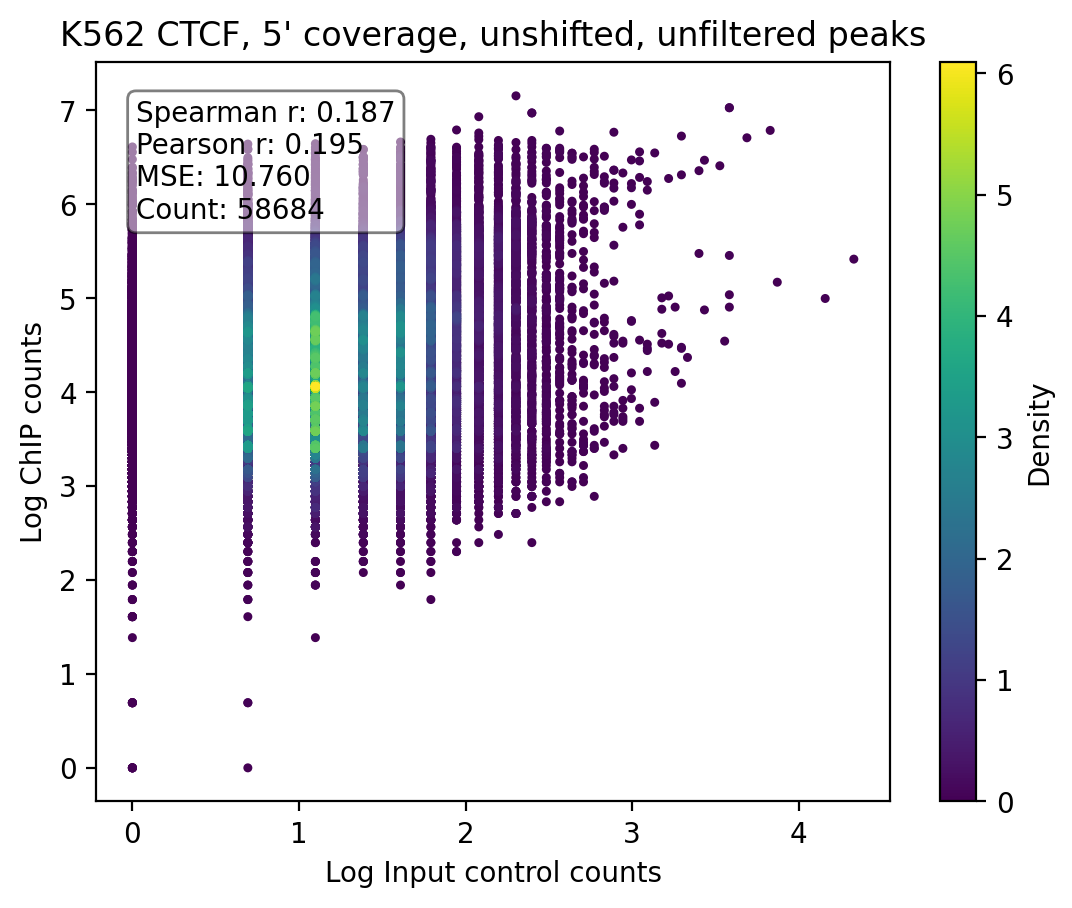

In [8]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/ENCFF660GHM.bed"
chip_cts, inputc_cts = get_corre(p, inputc_minus, inputc_plus, chip_minus, chip_plus)

# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 CTCF, 5' coverage, unshifted, unfiltered peaks")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 CTCF, 5' coverage, unshifted, unfiltered peaks")
plt.show()